In [1]:
# unzip dataset_letras.zip
!unzip dataset_letras_final.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_letras3/Q/Q_106.png  
 extracting: dataset_letras3/Q/Q_107.png  
 extracting: dataset_letras3/Q/Q_108.png  
 extracting: dataset_letras3/Q/Q_109.png  
 extracting: dataset_letras3/Q/Q_11.png  
 extracting: dataset_letras3/Q/Q_110.png  
 extracting: dataset_letras3/Q/Q_111.png  
 extracting: dataset_letras3/Q/Q_112.png  
 extracting: dataset_letras3/Q/Q_113.png  
 extracting: dataset_letras3/Q/Q_114.png  
 extracting: dataset_letras3/Q/Q_115.png  
 extracting: dataset_letras3/Q/Q_116.png  
 extracting: dataset_letras3/Q/Q_117.png  
 extracting: dataset_letras3/Q/Q_118.png  
 extracting: dataset_letras3/Q/Q_119.png  
 extracting: dataset_letras3/Q/Q_12.png  
 extracting: dataset_letras3/Q/Q_120.png  
 extracting: dataset_letras3/Q/Q_121.png  
 extracting: dataset_letras3/Q/Q_122.png  
 extracting: dataset_letras3/Q/Q_123.png  
 extracting: dataset_letras3/Q/Q_124.png  
 extracting: dataset_letras3/Q/Q_125.png  
 extr

In [2]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.0 MB/s eta 0:00:00


In [3]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andreu-mir. Use `wandb login --relogin` to force relogin


# 1. Arquitectura model

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNModel(nn.Module):
    def __init__(self):
        super(FCNModel, self).__init__()

        # Aplanar imágenes 1x64x40 a un vector de 2560 elementos (64*40)
        self.fc1 = nn.Linear(1 * 64 * 40, 512)  # Primera capa totalmente conectada
        self.fc2 = nn.Linear(512, 128)          # Segunda capa
        self.fc3 = nn.Linear(128, 26)           # Capa de salida para 26 clases
        self.dropout = nn.Dropout(0.5)          # Dropout para regularización

    def forward(self, x):
        x = x.view(-1, 1 * 64 * 40)             # Aplanar las imágenes (batch_size, 1*64*40)
        x = F.relu(self.fc1(x))                 # Capa oculta 1 con ReLU
        x = self.dropout(x)                     # Aplicar dropout
        x = F.relu(self.fc2(x))                 # Capa oculta 2 con ReLU
        x = self.fc3(x)                         # Capa de salida
        return x

# Crear una instancia del modelo
model = FCNModel()


# 2. Dataset

In [5]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="letra_recognition_FCN")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_letras3'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

Total dataset size: 13000


# 3. Train Model

In [6]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Epoch [1/20], Loss: 0.8433, Accuracy: 0.7812
Epoch [2/20], Loss: 0.5421, Accuracy: 0.8496
Epoch [3/20], Loss: 0.5044, Accuracy: 0.8555
Epoch [4/20], Loss: 0.4821, Accuracy: 0.8586
Epoch [5/20], Loss: 0.4550, Accuracy: 0.8693
Epoch [6/20], Loss: 0.4285, Accuracy: 0.8755
Epoch [7/20], Loss: 0.4048, Accuracy: 0.8787
Epoch [8/20], Loss: 0.4055, Accuracy: 0.8792
Epoch [9/20], Loss: 0.4006, Accuracy: 0.8804
Epoch [10/20], Loss: 0.3922, Accuracy: 0.8833
Epoch [11/20], Loss: 0.3766, Accuracy: 0.8861
Epoch [12/20], Loss: 0.3737, Accuracy: 0.8854
Epoch [13/20], Loss: 0.3576, Accuracy: 0.8937
Epoch [14/20], Loss: 0.3487, Accuracy: 0.8966
Epoch [15/20], Loss: 0.3381, Accuracy: 0.8975
Epoch [16/20], Loss: 0.3403, Accuracy: 0.8986
Epoch [17/20], Loss: 0.3304, Accuracy: 0.8996
Epoch [18/20], Loss: 0.3285, Accuracy: 0.9022
Epoch [19/20], Loss: 0.3207, Accuracy: 0.9032
Epoch [20/20], Loss: 0.3237, Accuracy: 0.9028
Validation Loss: 0.3106, Validation Accuracy: 0.9100
Validation Precision: 0.917

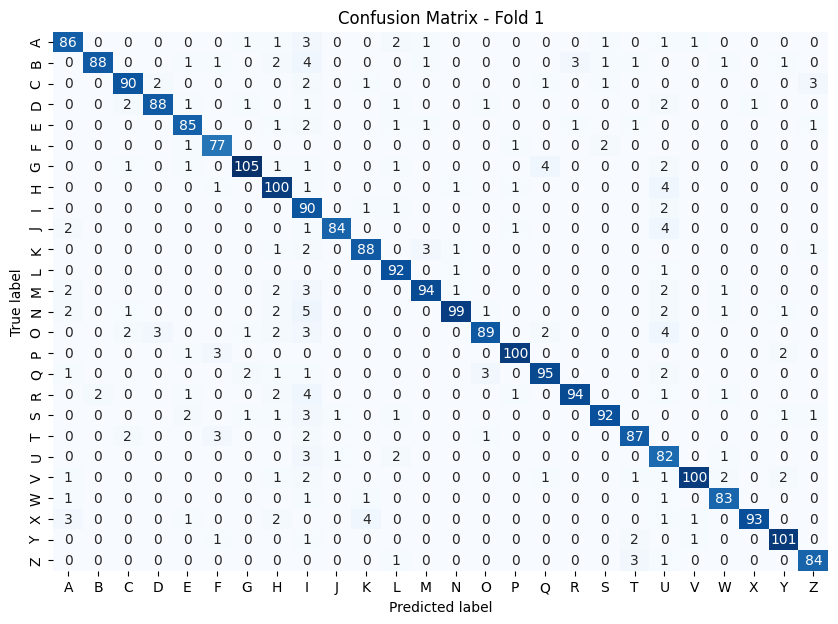

Fold 2/5
Epoch [1/20], Loss: 0.3512, Accuracy: 0.8954
Epoch [2/20], Loss: 0.3445, Accuracy: 0.8983
Epoch [3/20], Loss: 0.3301, Accuracy: 0.9003
Epoch [4/20], Loss: 0.3187, Accuracy: 0.9048
Epoch [5/20], Loss: 0.3184, Accuracy: 0.9053
Epoch [6/20], Loss: 0.3069, Accuracy: 0.9069
Epoch [7/20], Loss: 0.3139, Accuracy: 0.9057
Epoch [8/20], Loss: 0.2985, Accuracy: 0.9065
Epoch [9/20], Loss: 0.2990, Accuracy: 0.9080
Epoch [10/20], Loss: 0.3046, Accuracy: 0.9087
Epoch [11/20], Loss: 0.2954, Accuracy: 0.9093
Epoch [12/20], Loss: 0.3016, Accuracy: 0.9096
Epoch [13/20], Loss: 0.2950, Accuracy: 0.9135
Epoch [14/20], Loss: 0.2865, Accuracy: 0.9119
Epoch [15/20], Loss: 0.2826, Accuracy: 0.9146
Epoch [16/20], Loss: 0.2712, Accuracy: 0.9160
Epoch [17/20], Loss: 0.2853, Accuracy: 0.9166
Epoch [18/20], Loss: 0.2806, Accuracy: 0.9169
Epoch [19/20], Loss: 0.2803, Accuracy: 0.9165
Epoch [20/20], Loss: 0.2797, Accuracy: 0.9159
Validation Loss: 0.2315, Validation Accuracy: 0.9285
Validation Precision: 0.930

<Figure size 640x480 with 0 Axes>

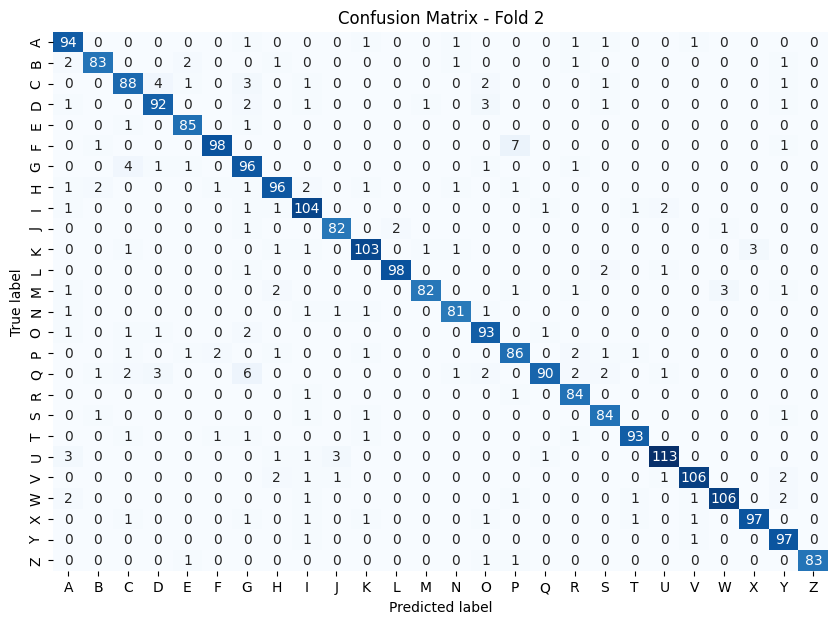

Fold 3/5
Epoch [1/20], Loss: 0.2988, Accuracy: 0.9123
Epoch [2/20], Loss: 0.2754, Accuracy: 0.9174
Epoch [3/20], Loss: 0.2787, Accuracy: 0.9172
Epoch [4/20], Loss: 0.2775, Accuracy: 0.9151
Epoch [5/20], Loss: 0.2732, Accuracy: 0.9174
Epoch [6/20], Loss: 0.2855, Accuracy: 0.9135
Epoch [7/20], Loss: 0.2868, Accuracy: 0.9149
Epoch [8/20], Loss: 0.2724, Accuracy: 0.9175
Epoch [9/20], Loss: 0.2748, Accuracy: 0.9178
Epoch [10/20], Loss: 0.2628, Accuracy: 0.9200
Epoch [11/20], Loss: 0.2614, Accuracy: 0.9206
Epoch [12/20], Loss: 0.2493, Accuracy: 0.9240
Epoch [13/20], Loss: 0.2485, Accuracy: 0.9262
Epoch [14/20], Loss: 0.2546, Accuracy: 0.9231
Epoch [15/20], Loss: 0.2601, Accuracy: 0.9226
Epoch [16/20], Loss: 0.2612, Accuracy: 0.9212
Epoch [17/20], Loss: 0.2606, Accuracy: 0.9238
Epoch [18/20], Loss: 0.2612, Accuracy: 0.9233
Epoch [19/20], Loss: 0.2473, Accuracy: 0.9270
Epoch [20/20], Loss: 0.2589, Accuracy: 0.9239
Validation Loss: 0.2339, Validation Accuracy: 0.9292
Validation Precision: 0.933

<Figure size 640x480 with 0 Axes>

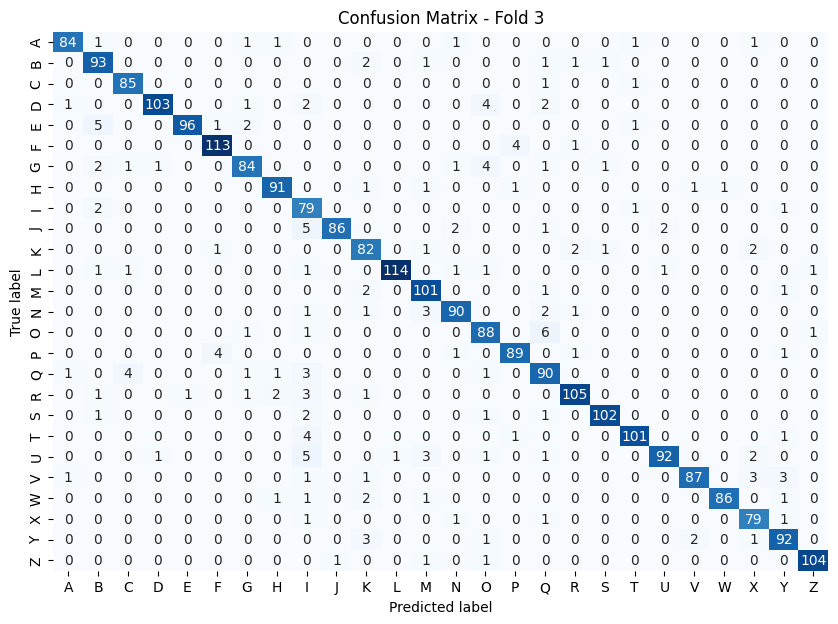

Fold 4/5
Epoch [1/20], Loss: 0.2888, Accuracy: 0.9160
Epoch [2/20], Loss: 0.2822, Accuracy: 0.9187
Epoch [3/20], Loss: 0.2558, Accuracy: 0.9230
Epoch [4/20], Loss: 0.2568, Accuracy: 0.9230
Epoch [5/20], Loss: 0.2476, Accuracy: 0.9258
Epoch [6/20], Loss: 0.2529, Accuracy: 0.9237
Epoch [7/20], Loss: 0.2556, Accuracy: 0.9227
Epoch [8/20], Loss: 0.2613, Accuracy: 0.9239
Epoch [9/20], Loss: 0.2538, Accuracy: 0.9258
Epoch [10/20], Loss: 0.2384, Accuracy: 0.9284
Epoch [11/20], Loss: 0.2549, Accuracy: 0.9243
Epoch [12/20], Loss: 0.2421, Accuracy: 0.9274
Epoch [13/20], Loss: 0.2429, Accuracy: 0.9287
Epoch [14/20], Loss: 0.2547, Accuracy: 0.9252
Epoch [15/20], Loss: 0.2467, Accuracy: 0.9283
Epoch [16/20], Loss: 0.2421, Accuracy: 0.9287
Epoch [17/20], Loss: 0.2559, Accuracy: 0.9258
Epoch [18/20], Loss: 0.2422, Accuracy: 0.9287
Epoch [19/20], Loss: 0.2363, Accuracy: 0.9290
Epoch [20/20], Loss: 0.2322, Accuracy: 0.9306
Validation Loss: 0.1958, Validation Accuracy: 0.9362
Validation Precision: 0.940

<Figure size 640x480 with 0 Axes>

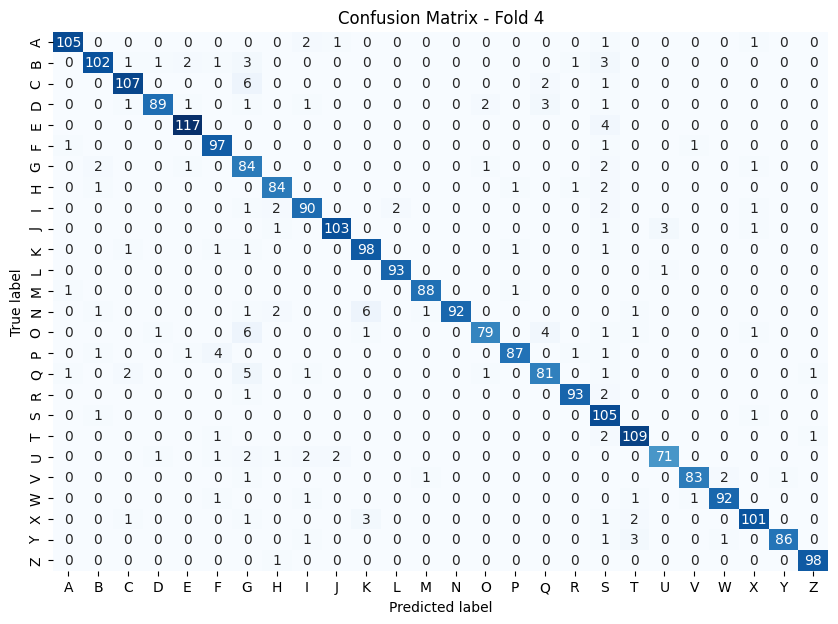

Fold 5/5
Epoch [1/20], Loss: 0.2654, Accuracy: 0.9244
Epoch [2/20], Loss: 0.2581, Accuracy: 0.9244
Epoch [3/20], Loss: 0.2620, Accuracy: 0.9258
Epoch [4/20], Loss: 0.2405, Accuracy: 0.9289
Epoch [5/20], Loss: 0.2417, Accuracy: 0.9297
Epoch [6/20], Loss: 0.2289, Accuracy: 0.9309
Epoch [7/20], Loss: 0.2570, Accuracy: 0.9263
Epoch [8/20], Loss: 0.2491, Accuracy: 0.9247
Epoch [9/20], Loss: 0.2361, Accuracy: 0.9293
Epoch [10/20], Loss: 0.2428, Accuracy: 0.9285
Epoch [11/20], Loss: 0.2507, Accuracy: 0.9284
Epoch [12/20], Loss: 0.2412, Accuracy: 0.9295
Epoch [13/20], Loss: 0.2370, Accuracy: 0.9313
Epoch [14/20], Loss: 0.2405, Accuracy: 0.9306
Epoch [15/20], Loss: 0.2542, Accuracy: 0.9275
Epoch [16/20], Loss: 0.2423, Accuracy: 0.9277
Epoch [17/20], Loss: 0.2324, Accuracy: 0.9303
Epoch [18/20], Loss: 0.2378, Accuracy: 0.9309
Epoch [19/20], Loss: 0.2379, Accuracy: 0.9337
Epoch [20/20], Loss: 0.2431, Accuracy: 0.9306
Validation Loss: 0.1735, Validation Accuracy: 0.9435
Validation Precision: 0.944

<Figure size 640x480 with 0 Axes>

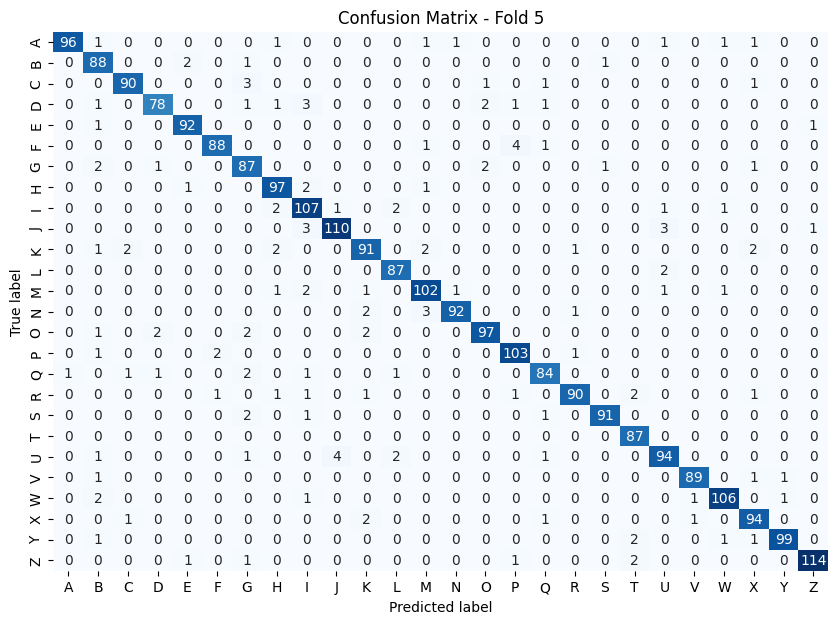

<Figure size 640x480 with 0 Axes>

In [8]:
# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    train_losses = []
    train_accuracies = []

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to('cuda')  # Usa 'cuda' si tienes GPU
            labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcula y registra la pérdida y la precisión
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
        })

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Calcula y muestra la pérdida y precisión de validación
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Calcular métricas adicionales
    precision = precision_score(val_labels, val_predictions, average='weighted')
    recall = recall_score(val_labels, val_predictions, average='weighted')
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    cm = confusion_matrix(val_labels, val_predictions)

    # Log métricas de validación a WandB
    wandb.log({
        "fold": fold + 1,
        "val_loss": val_epoch_loss,
        "val_accuracy": val_epoch_accuracy,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    })

    # Imprimir métricas
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Guardar la figura
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()
    plt.clf()  # Limpiar la figura para la próxima iteración




In [9]:
# Finaliza la sesión de WandB
wandb.finish()

accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,▁▂▃▃▄▇▇▇██▁▂▂▄▄▇▇██▁▃▄▄▄▅▆▇▇▂▃▅▆▇██▂▂▂▃▅
fold,▁▃▅▆█
loss,█▆▆▆▅▅▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▁▂▂▂
val_accuracy,▁▅▅▆█
val_f1,▁▅▅▇█
val_loss,█▄▄▂▁
val_precision,▁▄▅▇█
val_recall,▁▅▅▆█
accuracy,0.93058
epoch,20


In [10]:
model_save_path = f'model_letter_classifier_FCN.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_letter_classifier_FCN.pth
